# 🧪 Create a Benchmark and Evaluate Your Models

Evaluating models is only as good as the benchmark you test them against.  
In this tutorial, you’ll learn how to use **Label Studio** to create a high-quality benchmark dataset, label it with human expertise, and then evaluate multiple AI models against it — all using the **Label Studio SDK**.  

By the end, you’ll have a reproducible workflow to **measure and compare model performance** on your own data — moving beyond intuition and into measurable, data-driven insights.


## 🧠 What are benchmarks?

A **benchmark** is a trusted, labeled dataset used as a ground truth reference to evaluate model performance.  
Think of it as your *reality check* — it lets you see how well a model really understands your domain and tasks.  

Unlike public leaderboards or off-the-shelf test sets, a **custom benchmark** reflects *your data, your domain, and your definition of success*.  
For example, if you’re detecting phishing emails, your benchmark should include real examples of legitimate and malicious messages relevant to your context.

👉 To learn more about the role of benchmarks in AI evaluation, see [**Why Benchmarks Matter for Evaluating LLMs**](https://labelstud.io/blog/why-benchmarks-matter-for-evaluating-llms/).


## ⚖️ Why are benchmarks important?

Benchmarks are the backbone of **model evaluation and continuous improvement**. Without them, it’s hard to know if a new model or prompt version actually performs better — or just seems to.  

A good benchmark lets you:
- 🔁 Compare models from different providers on the *same data*  
- 🧩 Identify strengths and weaknesses across labels or categories  
- 📈 Track progress over time as your models evolve  
- ✅ Build trust in your model’s predictions through measurable accuracy  

In other words, benchmarks turn subjective “it looks better” claims into **objective evidence**.  
For a deeper look at this idea, check out [**How to Build AI Benchmarks That Evolve with Your Models**](https://labelstud.io/blog/how-to-build-ai-benchmarks-that-evolve-with-your-models/).


## ⚙️ How can I use Label Studio to create my benchmark?

Label Studio gives you everything you need to create, manage, and evolve your benchmark — all in one platform.  
With it, you can:
- 📥 **Import and label your data** collaboratively or programmatically  
- 🧭 **Version and refine** your benchmark as your understanding improves  
- 🤖 **Run model evaluations** directly using the SDK and built-in prompt management tools  

This makes your benchmarks *living assets* that adapt as your data and models grow.  
For inspiration, see how others are building domain-specific benchmarks in [**How LegalBenchmarks.AI Built a Domain-Specific AI Benchmark**](https://labelstud.io/blog/how-legalbenchmarks-ai-built-a-domain-specific-ai-benchmark/).


## 🎓 What is this tutorial going to teach me?

In this tutorial, you’ll learn how to:
1. 🏗️ Create a benchmark project in Label Studio using the SDK  
2. 📊 Import and label your own dataset  
3. 💬 Define prompts and model versions to evaluate  
4. 📉 Run evaluations and visualize results  

We’ll also walk through an example comparing several models on a phishing email classification task — similar to how we evaluated models in [**Evaluating the GPT-5 Series on Custom Benchmarks**](https://labelstud.io/blog/evaluating-the-gpt-5-series-on-custom-benchmarks/).  

By the end, you’ll have a repeatable workflow to **evaluate any model** on **any dataset** — grounded in your own benchmark.

## 🚀 Before You Start

Before diving into the code, let’s make sure you have everything set up to follow along.  

You’ll only need a few things to get started 👇

### 🧰 Prerequisites
> **Note:** This tutorial is available for **Label Studio Enterprise** and **Starter Cloud** users, since it uses features like **Prompts** and **Agreement Metrics** that aren’t available in the open-source version.

If you’re using the open-source version of Label Studio, you can still follow along conceptually.  
👉 Learn more or request access at [**humansignal.com**](https://humansignal.com/).

You’ll need:
- A **Label Studio account** on [app.humansignal.com](https://app.humansignal.com/)  
  _(Starter Cloud or Enterprise edition required)_  
- An **API key** from your user settings (you’ll use it to connect via the SDK)  
- Access to a **workspace** where you can create projects


### 🧩 What you’ll be using
We’ll use the **Label Studio SDK** to:
- Connect to your Label Studio instance  
- Create a project and import data  
- Define prompts and model versions  
- Run model evaluations and visualize the results  

Everything happens programmatically — no need to click around the UI (though you can open your Label Studio anytime to see what’s happening 👀).

Let's dive in 🚀


### ⚙️ Install the SDK and connect to Label Studio

Let’s start by installing the SDK, configuring your connection details, and testing the connection.



In [ ]:
# Run this cell to install the Label Studio SDK
!pip install label-studio-sdk>=2.0.11

In [ ]:
# Configure your connection details

# URL of your Label Studio instance
LABEL_STUDIO_URL = 'https://app.humansignal.com/'

# Your API key (find it in Account & Settings > Personal Access Token)
API_KEY = '<Token>'

# ID of the workspace to create the project (make sure it's not the Personal Sandbox)
# Find the Workspace ID in the URL when you click on it in the sidebar
WORKSPACE_ID = 0

In [ ]:
# Check you can connect to Label Studio
from label_studio_sdk import LabelStudio

ls = LabelStudio(base_url=LABEL_STUDIO_URL, api_key=API_KEY)
user = ls.users.whoami()
print(f'Connected as {user.email}')

Connected as marcel@humansignal.com


### Create a Project and Import the Email Dataset

1. We'll start by creating a **Label Studio project** with a labeling configuration that lets us classify each email as either **Phishing** or **Legitimate**.  
   - If **Phishing** is selected, annotators can also choose one or more **phishing types** and **indicators** to describe the attack.

2. Next, we’ll **download a dataset of raw emails** that we’ll use as the benchmark data.

3. Finally, we’ll **import the dataset as tasks into Label Studio**, so we can begin labeling and building our benchmark.

In [ ]:
label_config = '''
<View>
  <View className="section">
    <Text name="body" value="$raw_email" />
  </View>

  <View className="section">
    <Header value="Overall classification" size="3" />
    <Choices name="classification" toName="body" choice="single" showInline="true" required="true">
      <Choice value="Phishing" />
      <Choice value="Legitimate" />
    </Choices>
  </View>

  <View className="section" visibleWhen="choice-selected" whenTagName="classification" whenChoiceValue="Phishing,Suspicious">
    <Header value="Phishing type" size="3" />
    <Choices name="phishing_type" toName="body" choice="multiple" showInline="false">
      <Choice value="Credential Harvesting - Fake login page" />
      <Choice value="Malware Delivery - Link to download malware" />
      <Choice value="Malware Delivery - Malicious Link / Phishing Site" />
      <Choice value="Financial Fraud - Gift Card Scam" />
      <Choice value="Financial Fraud - BEC (Impersonation/CEO Fraud)" />
      <Choice value="Extortion/Blackmail" />
      <Choice value="Account Suspension Notice" />
      <Choice value="Social Engineering - Romance / Dating Scam" />
      <Choice value="Other" />
    </Choices>

    <Header value="Indicators observed" size="3" />
    <Choices name="indicators" toName="body" choice="multiple" showInline="false">
      <Choice value="Sender anomalies - Display name spoofing" />
      <Choice value="Sender anomalies - Lookalike domain" />
      <Choice value="Sender anomalies - Spoofed IP / Email headers indicate fraud" />
      <Choice value="Content signals - Urgency/Threats" />
      <Choice value="Content signals - Requests money/gift cards" />
      <Choice value="Content signals - Poor grammar/spelling" />
      <Choice value="Content signals - Unexpected attachment" />
      <Choice value="Content signals - Generic greeting (Dear user, etc.)" />
      <Choice value="Link issues - Obfuscated/shortened URL" />
      <Choice value="Link issues - Domain mismatch with brand" />
      <Choice value="Link issues - IP-based URL" />
      <Choice value="Other - Request for personal info unrelated to workflow" />
    </Choices>
  </View>
</View>
'''
# Creating project in the configured workspace
project = ls.projects.create(
    title='Phishing Benchmark Tutorial',
    workspace=WORKSPACE_ID,
    is_published=True,
    label_config=label_config
)

In [ ]:
# Download emails dataset
import pandas as pd
DATASET_URL = 'https://gist.githubusercontent.com/mcanu/95507352bfc4557d0ff0430117758abe/raw/eb86433f4c40645d0b1b717877d3468456ab687a/raw_emails.csv'
raw_emails = pd.read_csv(DATASET_URL)
raw_emails.head()

,raw_email
0,Subject: Meeting Confirmation for Project Upda...
1,Subject: Invitation to Annual Team Luncheon\n\...
2,```\nFrom: john.doe@example.com\nTo: jane.smit...
3,Subject: Team Meeting Reminder - Thursday at 1...
4,Subject: Team Meeting Scheduled for Thursday\n...


In [ ]:
# Import raw emails as tasks to Label Studio
ls.projects.import_tasks(project.id, request=raw_emails.to_dict(orient='records'))

ProjectsImportTasksResponse(annotation_count=None, could_be_tasks_list=None, data_columns=None, duration=None, file_upload_ids=None, found_formats=None, predictions_count=None, task_count=None, import=3058032)

### Label Your Benchmark

Now, if you go to **Label Studio**, you should see your newly imported tasks in the **Data Manager**.  

Click **Label All Tasks** to start labeling your benchmark.  
These labeled tasks will serve as your **ground truth** — the foundation for evaluating how well different models perform.  

*(You can refer to the screenshots below to follow along.)*



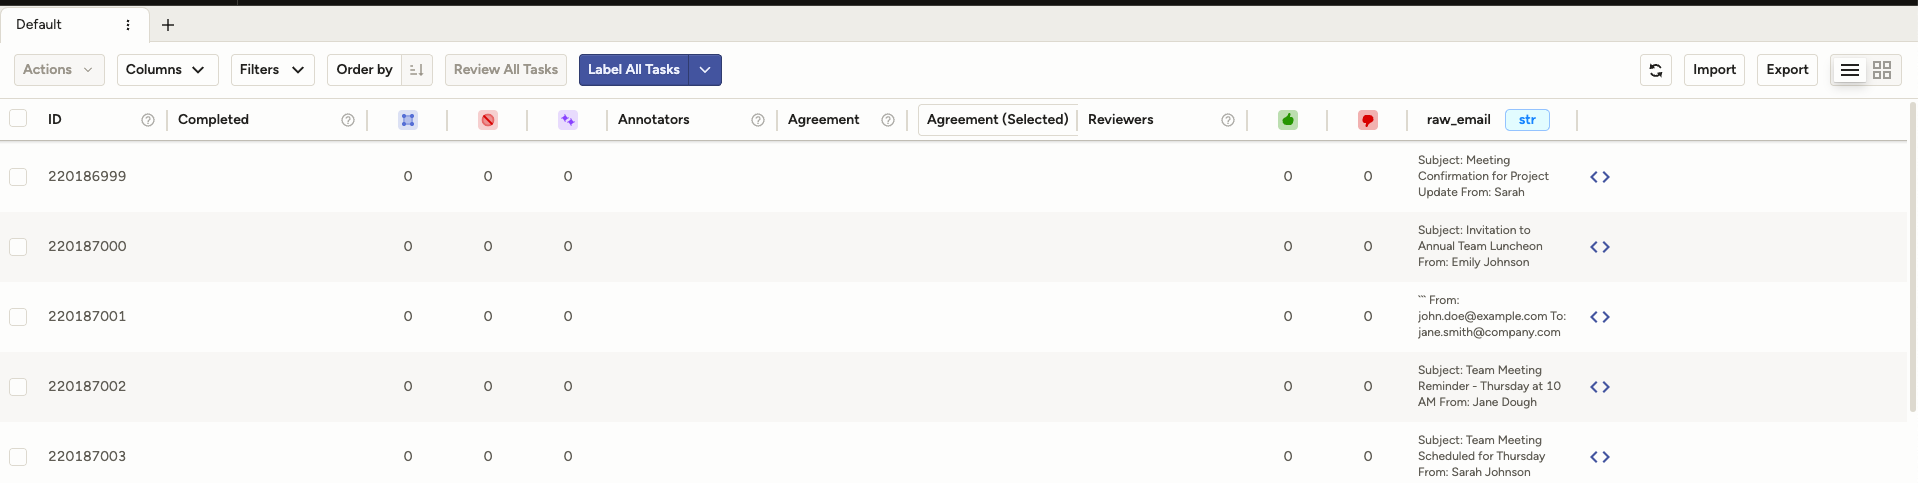

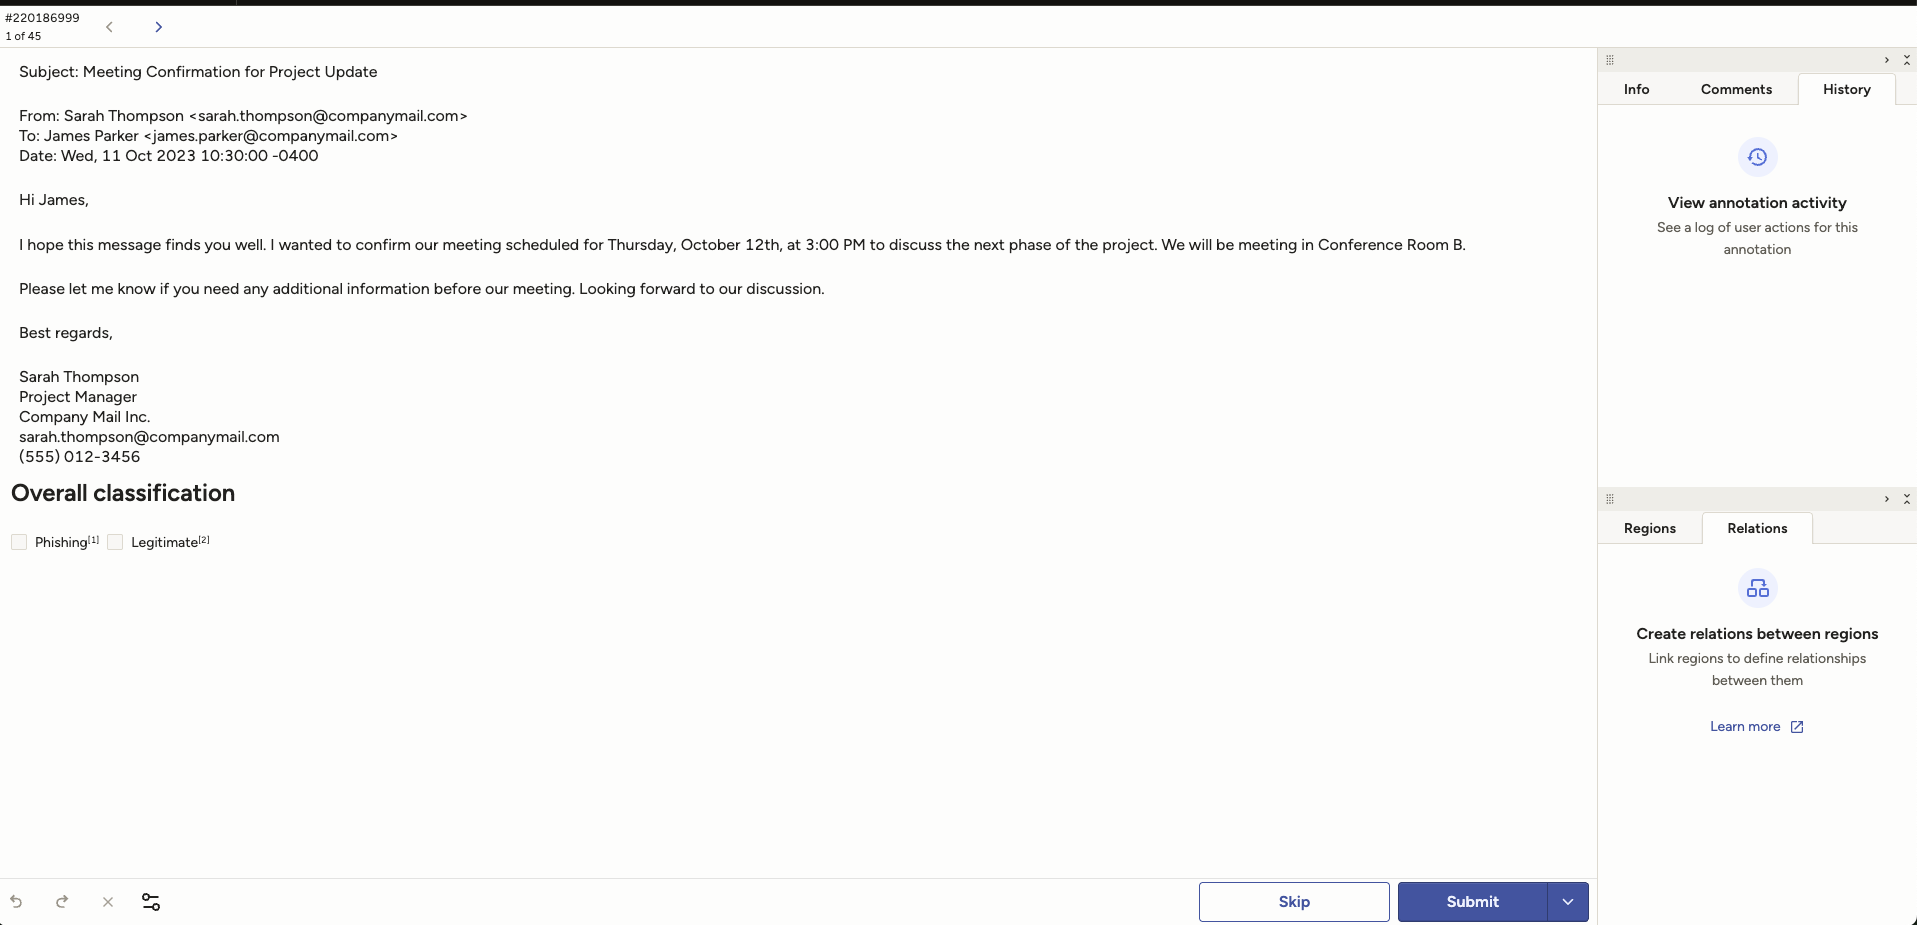

#### Set Annotations as Ground Truth

Mark your completed annotations as **ground truth**.  
This tells Label Studio which annotations to treat as the **source of truth** — enabling more accurate and meaningful **agreement metrics** when comparing model predictions against human labels.

In [ ]:
# Set your annotations as ground truth
ls.actions.create(id='set_ground_truths', project=project.id, request_options={'additional_body_parameters': {'annotator': user.id}})

None


### Configure Prompts for Model Predictions

**Prompts** let you connect and evaluate different AI models directly from Label Studio — using a shared prompt template to generate consistent predictions.  

Before running evaluations, go to [app.humansignal.com/prompts](https://app.humansignal.com/prompts) and configure the **API keys** for the models you want to test.  
You can also add **custom model connections** to evaluate your own or third-party models.  

For more details, see the [Prompts configuration guide](https://docs.humansignal.com/guide/prompts_keys).

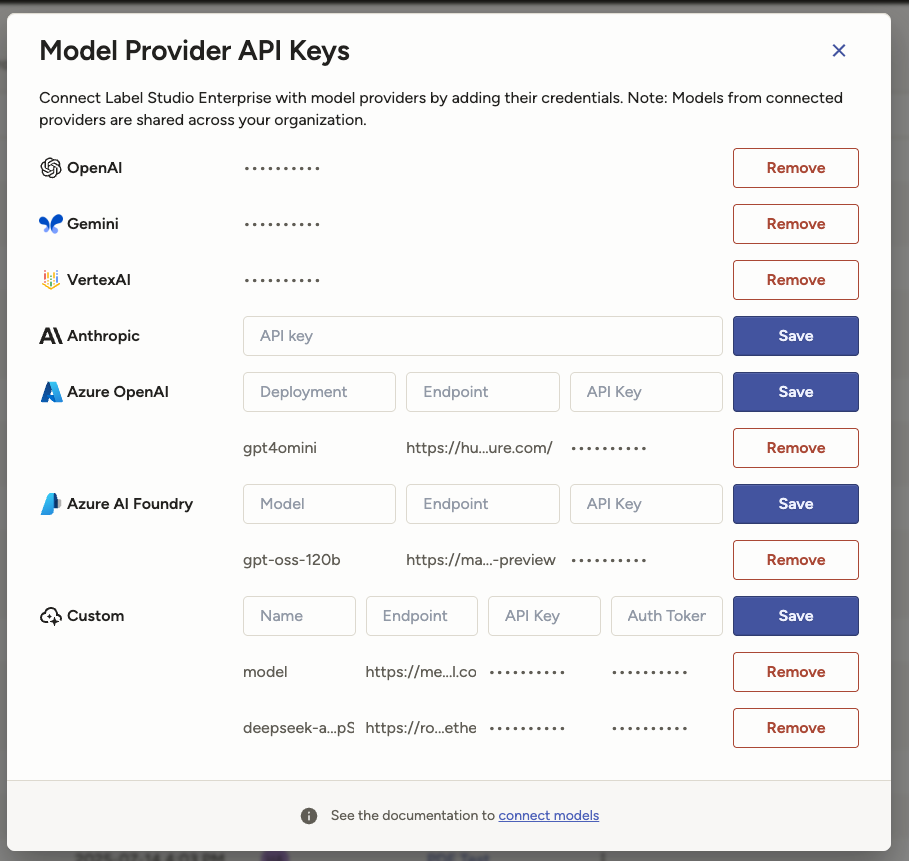

### Create and Run Model Versions with the SDK

Next, we’ll use the **Label Studio SDK** to automate the process of model evaluation.  
We’ll create a **prompt** linked to our project, then generate a **model version** for each model we want to test.  

Each model version will run inference on **all tasks in the project**, producing **one prediction per model per task** — ready for comparison against the ground truth.

In [ ]:
# Create new prompt for our project
prompt = ls.prompts.create(
    title='Phishing Benchmark Tutorial Prompt',
    associated_projects=[project.id],
    input_fields=['raw_email'],
)

In [ ]:
# We will be testing with 4 models from 2 different providers
models = {
    'OpenAI': {
        'id': None,
        'models': ['gpt-5-mini', 'gpt-4.1-mini'],
      },
    'Gemini': {
        'id': None,
        'models': ['gemini-2.0-flash-lite', 'gemini-2.5-flash-lite']
    }
}
providers = ls.model_providers.list()

# Assign provideer ids to models
for provider in providers:
    model_info = models.get(provider.provider)
    if model_info:
      model_info['id'] = provider.id
      models[provider.provider] = model_info


In [ ]:
PROMPT = '''
Analyze the provided email content and classify it as either 'Phishing' or 'Legitimate'.

If the email is classified as 'Phishing', identify the specific phishing type(s) and indicators from the options.
If the email is legitimate, classify it as 'Legitimate' with no additional phishing type or indicators.

Use the following variable in your analysis:
"{raw_email}"

Provide the output in JSON format with the keys:
- classification: 'Phishing' or 'Legitimate'
- phishing_type: list of strings (if applicable)
- indicators: list of strings (if applicable)

Ensure the response adheres to the provided JSON schema.
'''

# Create one prompt version for each model
versions = []
for provider, info in models.items():
    for model_name in info['models']:
      version = ls.prompts.versions.create(
          prompt_id=prompt.id,
          prompt=PROMPT,
          provider_model_id=model_name,
          title=f'{provider} - {model_name}',
          model_provider_connection=info['id'],

      )
      versions.append(version)


In [ ]:
# Run inference for each version
import time

# Function to wait for runs to complete
def wait_for_runs_to_complete(versions):
  completed_versions = []
  while len(completed_versions) != len(versions):
    for version in versions:
      if version in completed_versions:
        continue
      runs = ls.prompts.runs.list(prompt_id=prompt.id, version_id=version.id)
      if runs:
        last_run = runs[-1]
        if last_run.status == 'Completed':
          print('version ', version.id, ' completed')
          completed_versions.append(version)
    time.sleep(10)

# Launch runs for all versions
for version in versions:
  ls.prompts.runs.create(prompt_id=prompt.id, version_id=version.id, project=project.id, project_subset='All')

# Wait for runs to complete
wait_for_runs_to_complete(versions)

version  46550  completed
version  46551  completed
version  46552  completed
version  46549  completed


In [ ]:
project = ls.projects.get(193733)
prompt = ls.prompts.get(37050)
versions = ls.prompts.versions.list(prompt_id=prompt.id)

/usr/local/lib/python3.12/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=[], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=90367, input_type=int])
  return self.__pydantic_serializer__.to_python(


### Collect Run Costs

Let’s retrieve the **costs for each model run** to include them as additional data points.  
Tracking run costs alongside performance metrics helps you understand the **trade-off between accuracy and efficiency** for each model.

In [ ]:
# Collect costs from each run
costs = {}
for version in versions:
  runs = ls.prompts.runs.list(prompt_id=prompt.id, version_id=version.id)
  last_run = runs[-1]
  cost = ls.prompts.indicators.get(id=last_run.id, indicator_key='inference_cost')
  costs[version.title] = {
      'Total Cost': cost.values.get('total_cost'),
      'Completions Token Count': cost.values.get('completion_tokens_count'),
      'Prompt Token Count': cost.values.get('prompt_tokens_count'),
  }

In [ ]:
import pandas as pd

# Use the existing costs dictionary to create the DataFrame
cost_df = pd.DataFrame.from_dict(costs, orient='index')
cost_df = cost_df.reset_index().rename(columns={'index': 'Model Version'})

display(cost_df)

,Model Version,Total Cost,Completions Token Count,Prompt Token Count
0,OpenAI - gpt-5-mini,$0.046268,18221,39305
1,Gemini - gemini-2.0-flash-lite,$0.003896,1918,44281
2,Gemini - gemini-2.5-flash-lite,$0.005234,1934,44606
3,OpenAI - gpt-4.1-mini,$0.01862,1800,39350


# 📈 Analyze Results

Now that all model predictions are complete, we can use the **agreement metrics** provided by Label Studio to measure performance.  

Let’s start by looking at the **overall agreement** each model achieved against the ground truth annotations.  
This metric shows the **percentage of agreement** between each model’s predictions and your benchmark labels — giving a quick snapshot of model accuracy.

In [ ]:
def get_version_name(prompt, version):
  return f'{prompt.title}__{version.title}'


gt_agreements = []
for version in versions:
  version_name = get_version_name(prompt, version)
  agreement = ls.projects.stats.model_version_ground_truth_agreement(id=project.id, model_version=version_name)
  gt_agreements.append(agreement)

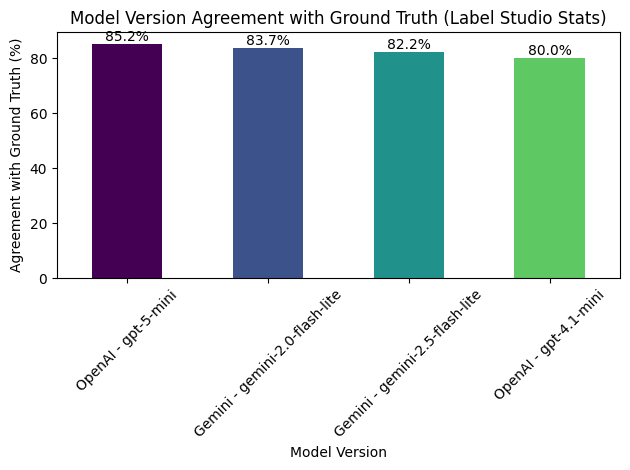

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'versions' and 'prompt' are available from previous cells
version_names = [version.title for version in versions]
agreement_values = [item.agreement * 100 for item in gt_agreements]

gt_agreement_df = pd.DataFrame({
    'Model Version': version_names,
    'Agreement (%)': agreement_values
})

gt_agreement_df = gt_agreement_df.sort_values('Agreement (%)', ascending=False)

ax = gt_agreement_df.plot.bar(x='Model Version', y='Agreement (%)', legend=False, rot=45, color=plt.cm.viridis(gt_agreement_df.index / len(gt_agreement_df)))
plt.ylabel('Agreement with Ground Truth (%)')
plt.xlabel('Model Version')
plt.title('Model Version Agreement with Ground Truth (Label Studio Stats)')

# Add agreement percentages on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.show()

## Agreement per Label

Next, let’s explore the **agreement per label** to see how each model performed across different categories.  

This view highlights where models **aligned with** or **deviated from** the benchmark — both in the main email classification and in the specific **phishing types** and **indicators**.  

These insights are extremely valuable for identifying **where models struggle** and **which areas to focus on** when fine-tuning to achieve better results.

In [ ]:
# Agreement per label

per_label_agreements = []
for version in versions:
  version_name = get_version_name(prompt, version)
  agreement = ls.projects.stats.model_version_ground_truth_agreement(id=project.id, model_version=version_name, per_label=True)
  per_label_agreements.append(agreement)

In [ ]:
import pandas as pd

per_label_data = {'Total Cost': {}}
for i, version_agreement in enumerate(per_label_agreements):
    version_name = versions[i].title
    for label, agreement in version_agreement.agreement.items():
        if label not in per_label_data:
            per_label_data[label] = {}
        per_label_data[label][version_name] = agreement * 100 # Convert to percentage
    per_label_data['Total Cost'][version_name] = costs[version_name]['Total Cost']

per_label_df = pd.DataFrame.from_dict(per_label_data, orient='index')
per_label_df = per_label_df.fillna(0) # Fill missing values with 0 if a label doesn't appear for a model

# Add color to the table and format percentages, excluding the 'Total Cost' row
per_label_df.style.background_gradient(cmap='Pastel1', subset=pd.IndexSlice[per_label_df.index != 'Total Cost', :]).format("{:.1f}%", subset=pd.IndexSlice[per_label_df.index != 'Total Cost', :])

,OpenAI - gpt-5-mini,Gemini - gemini-2.0-flash-lite,Gemini - gemini-2.5-flash-lite,OpenAI - gpt-4.1-mini
Total Cost,$0.046268,$0.003896,$0.005234,$0.01862
Phishing,100.0%,100.0%,100.0%,100.0%
Legitimate,100.0%,100.0%,100.0%,100.0%
Credential Harvesting - Fake login page,46.2%,33.3%,18.2%,20.0%
Account Suspension Notice,50.0%,0.0%,22.2%,0.0%
Sender anomalies - Lookalike domain,26.7%,27.3%,26.7%,0.0%
Content signals - Urgency/Threats,26.7%,26.7%,26.7%,6.7%
Link issues - Domain mismatch with brand,26.7%,26.7%,26.7%,6.7%
Malware Delivery - Malicious Link / Phishing Site,0.0%,16.7%,0.0%,0.0%


## 🎯 Wrapping Up

Congrats — you’ve just built your own **benchmark** for phishing email classification using **Label Studio**!  

With just a few steps, you created a setup that lets you:
- 🧠 Evaluate how well an LLM classifies phishing vs. legitimate emails  
- 📊 Visualize and compare model outputs in a structured, repeatable way  
- 🔄 Build a foundation that can evolve as your models improve  

### 💡 Why Benchmarks Matter

Benchmarks are essential for understanding how your models behave — not just whether they “work.”  
They help you:
- Identify **strengths and weaknesses** in model reasoning  
- Track **progress over time** as your system improves  
- Build **trust and transparency** around performance  

Benchmarks aren’t static — they evolve.  
You can continuously expand this benchmark with new examples or categories as your needs grow.

### 🧩 Why Label Studio

Label Studio makes this process simple and collaborative:
- Create, manage, and version **custom benchmarks**  
- **Evaluate multiple models** on the same dataset  
- **Visualize metrics and insights** directly from your labeled data  
- Integrate results into your existing ML pipeline for continuous improvement  

That’s exactly how teams like [*LegalBenchmarks.AI*](https://labelstud.io/blog/how-legalbenchmarks-ai-built-a-domain-specific-ai-benchmark/) build reliable, evolving benchmarks across domains.  

### 🚀 Next Steps

Keep iterating on what you built today:
- 🧪 Add more data or expand your label schema  
- 🤖 Compare different LLMs or prompt variations  
- 📈 Analyze where your model struggles — and why  
- 🔗 Share or automate your evaluation process with your team

### 📚 Learn More

- [Label Studio Documentation](https://docs.humansignal.com/guide/)  
- [Label Studio SDK](https://humansignal.github.io/label-studio-sdk/)  
- [Blog: Why Benchmarks Matter for Evaluating LLMs](https://labelstud.io/blog/why-benchmarks-matter-for-evaluating-llms/)  
- [Blog: How to Build AI Benchmarks That Evolve with Your Models](https://labelstud.io/blog/how-to-build-ai-benchmarks-that-evolve-with-your-models/)  
- [Blog: Evaluating the GPT-5 Series on Custom Benchmarks](https://labelstud.io/blog/evaluating-the-gpt-5-series-on-custom-benchmarks/)  
- [Blog: How LegalBenchmarks.AI Built a Domain-Specific AI Benchmark](https://labelstud.io/blog/how-legalbenchmarks-ai-built-a-domain-specific-ai-benchmark/)  